In [615]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [616]:
df = pd.read_csv('train.csv')

In [617]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<AxesSubplot:>

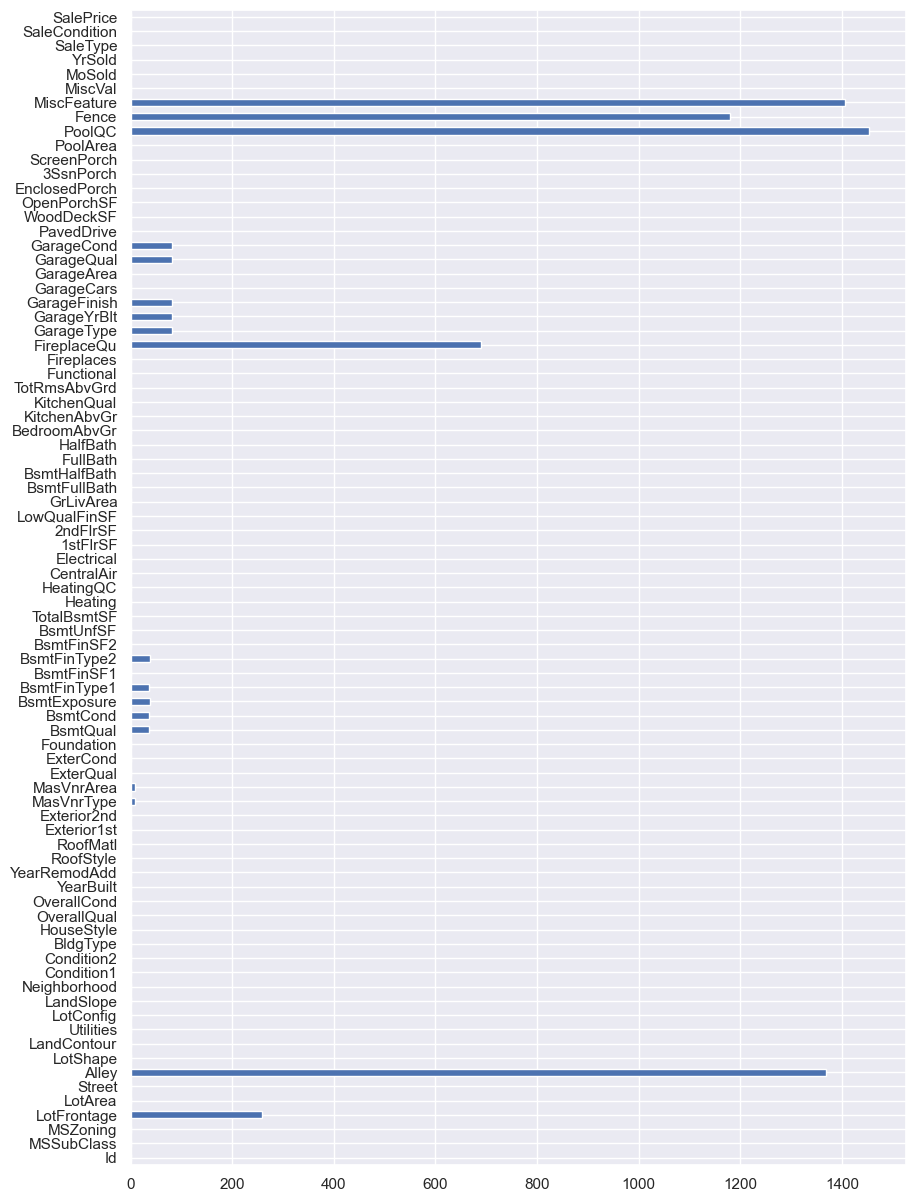

In [618]:
plt.figure(figsize=(10,15))
plt.tight_layout()
df.isnull().sum().plot(kind = 'barh')

In [619]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Data Understanding

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

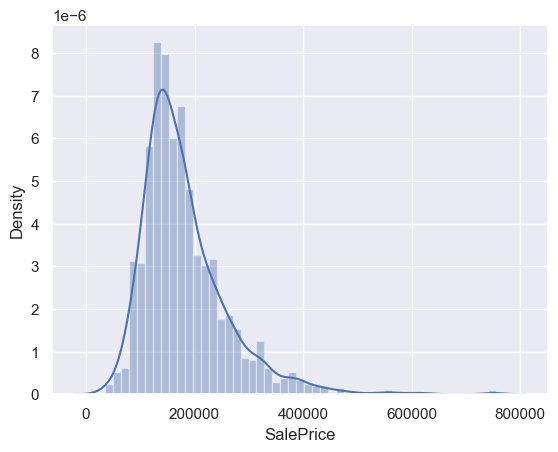

In [620]:
sns.distplot(df['SalePrice'])

#### Most of the house purchases are centered at 200000

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


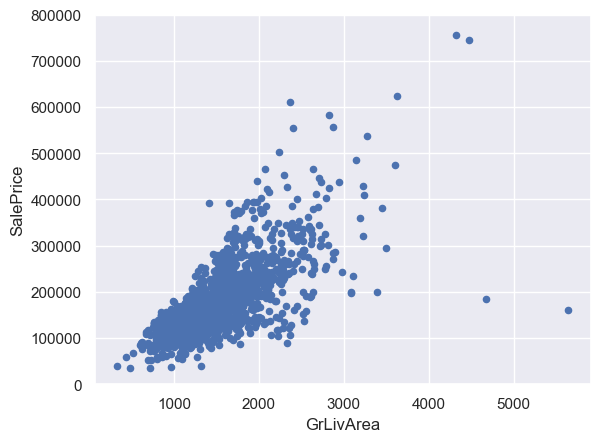

In [621]:
var = 'GrLivArea'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

#### AS GrLivArea increases SalePrice increases

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


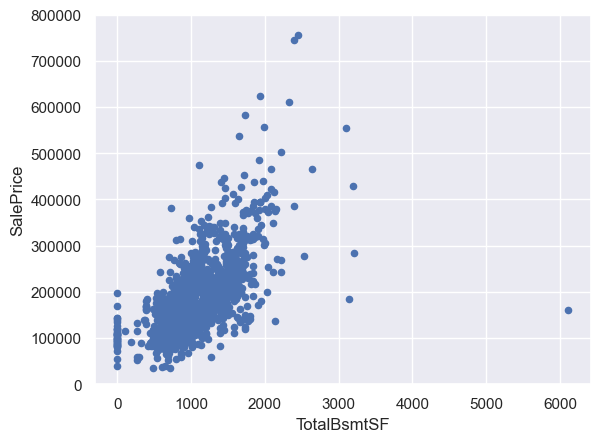

In [622]:
var = 'TotalBsmtSF'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

#### As GrLivArea increases SalePrice increases

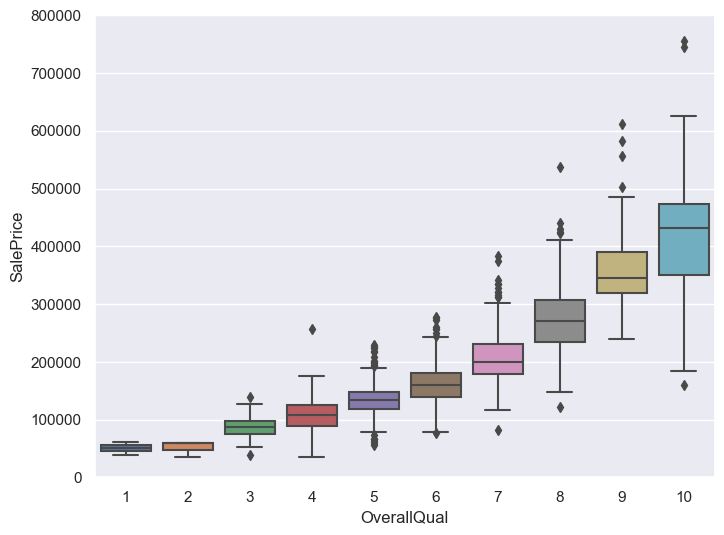

In [623]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

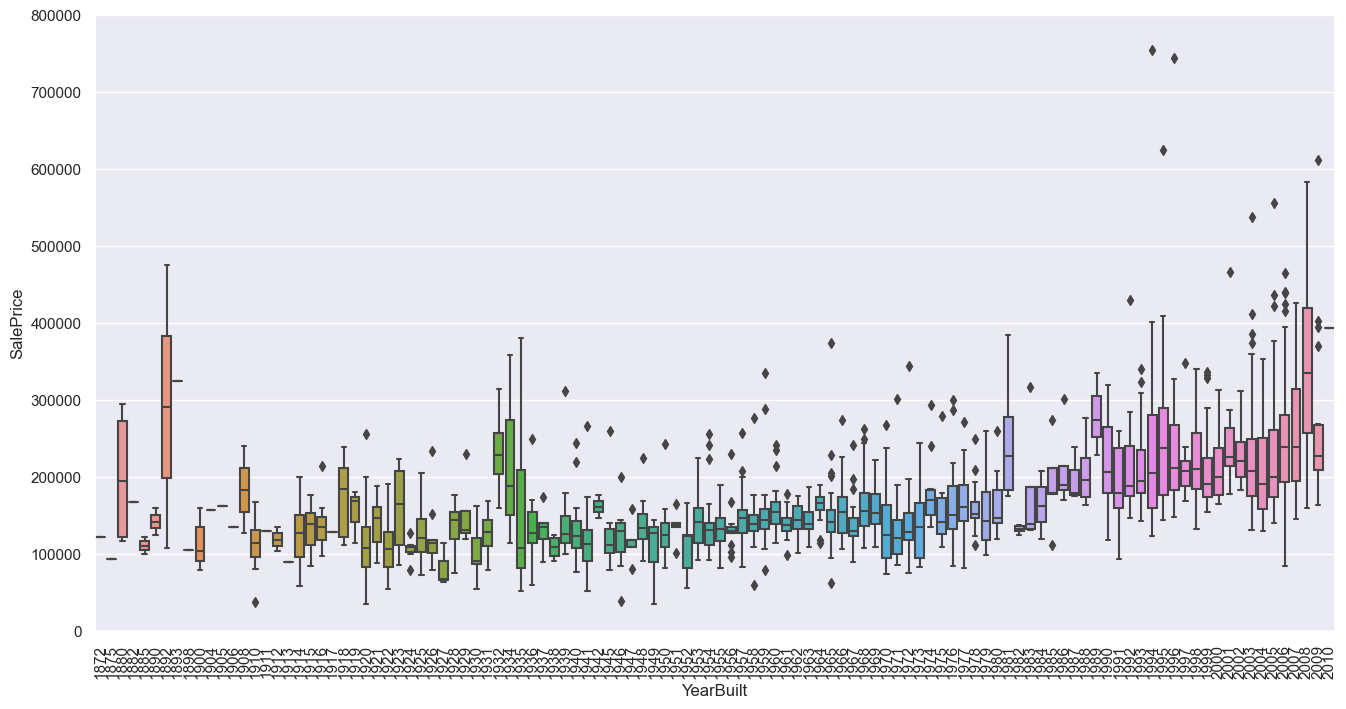

In [624]:
var = 'YearBuilt'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

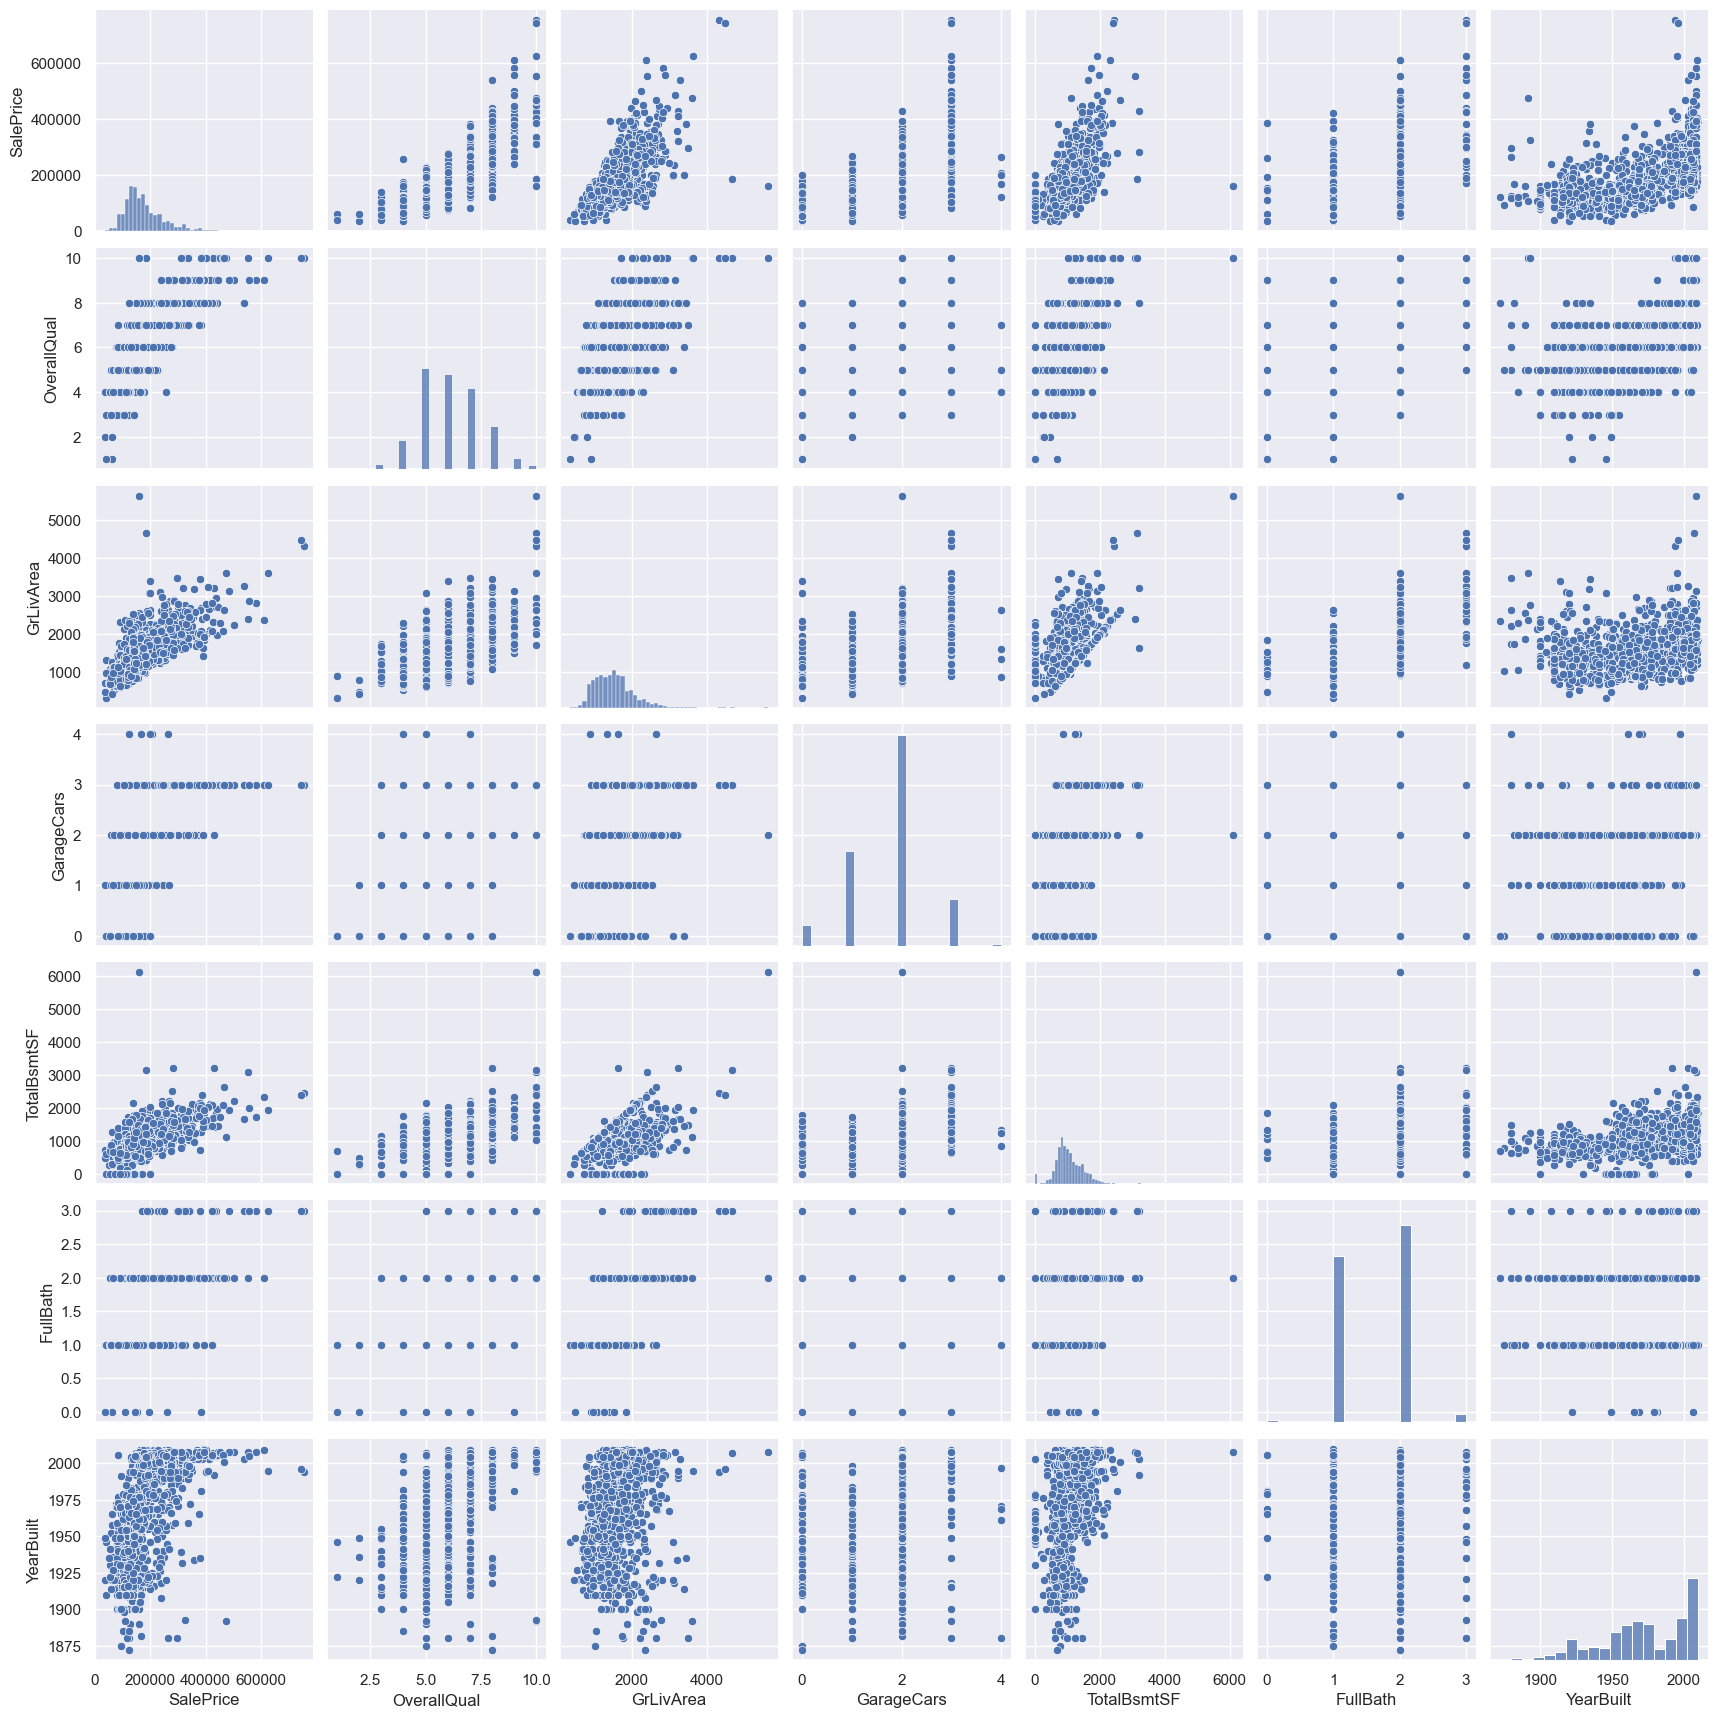

In [625]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df[cols], size = 2.5)
plt.show();

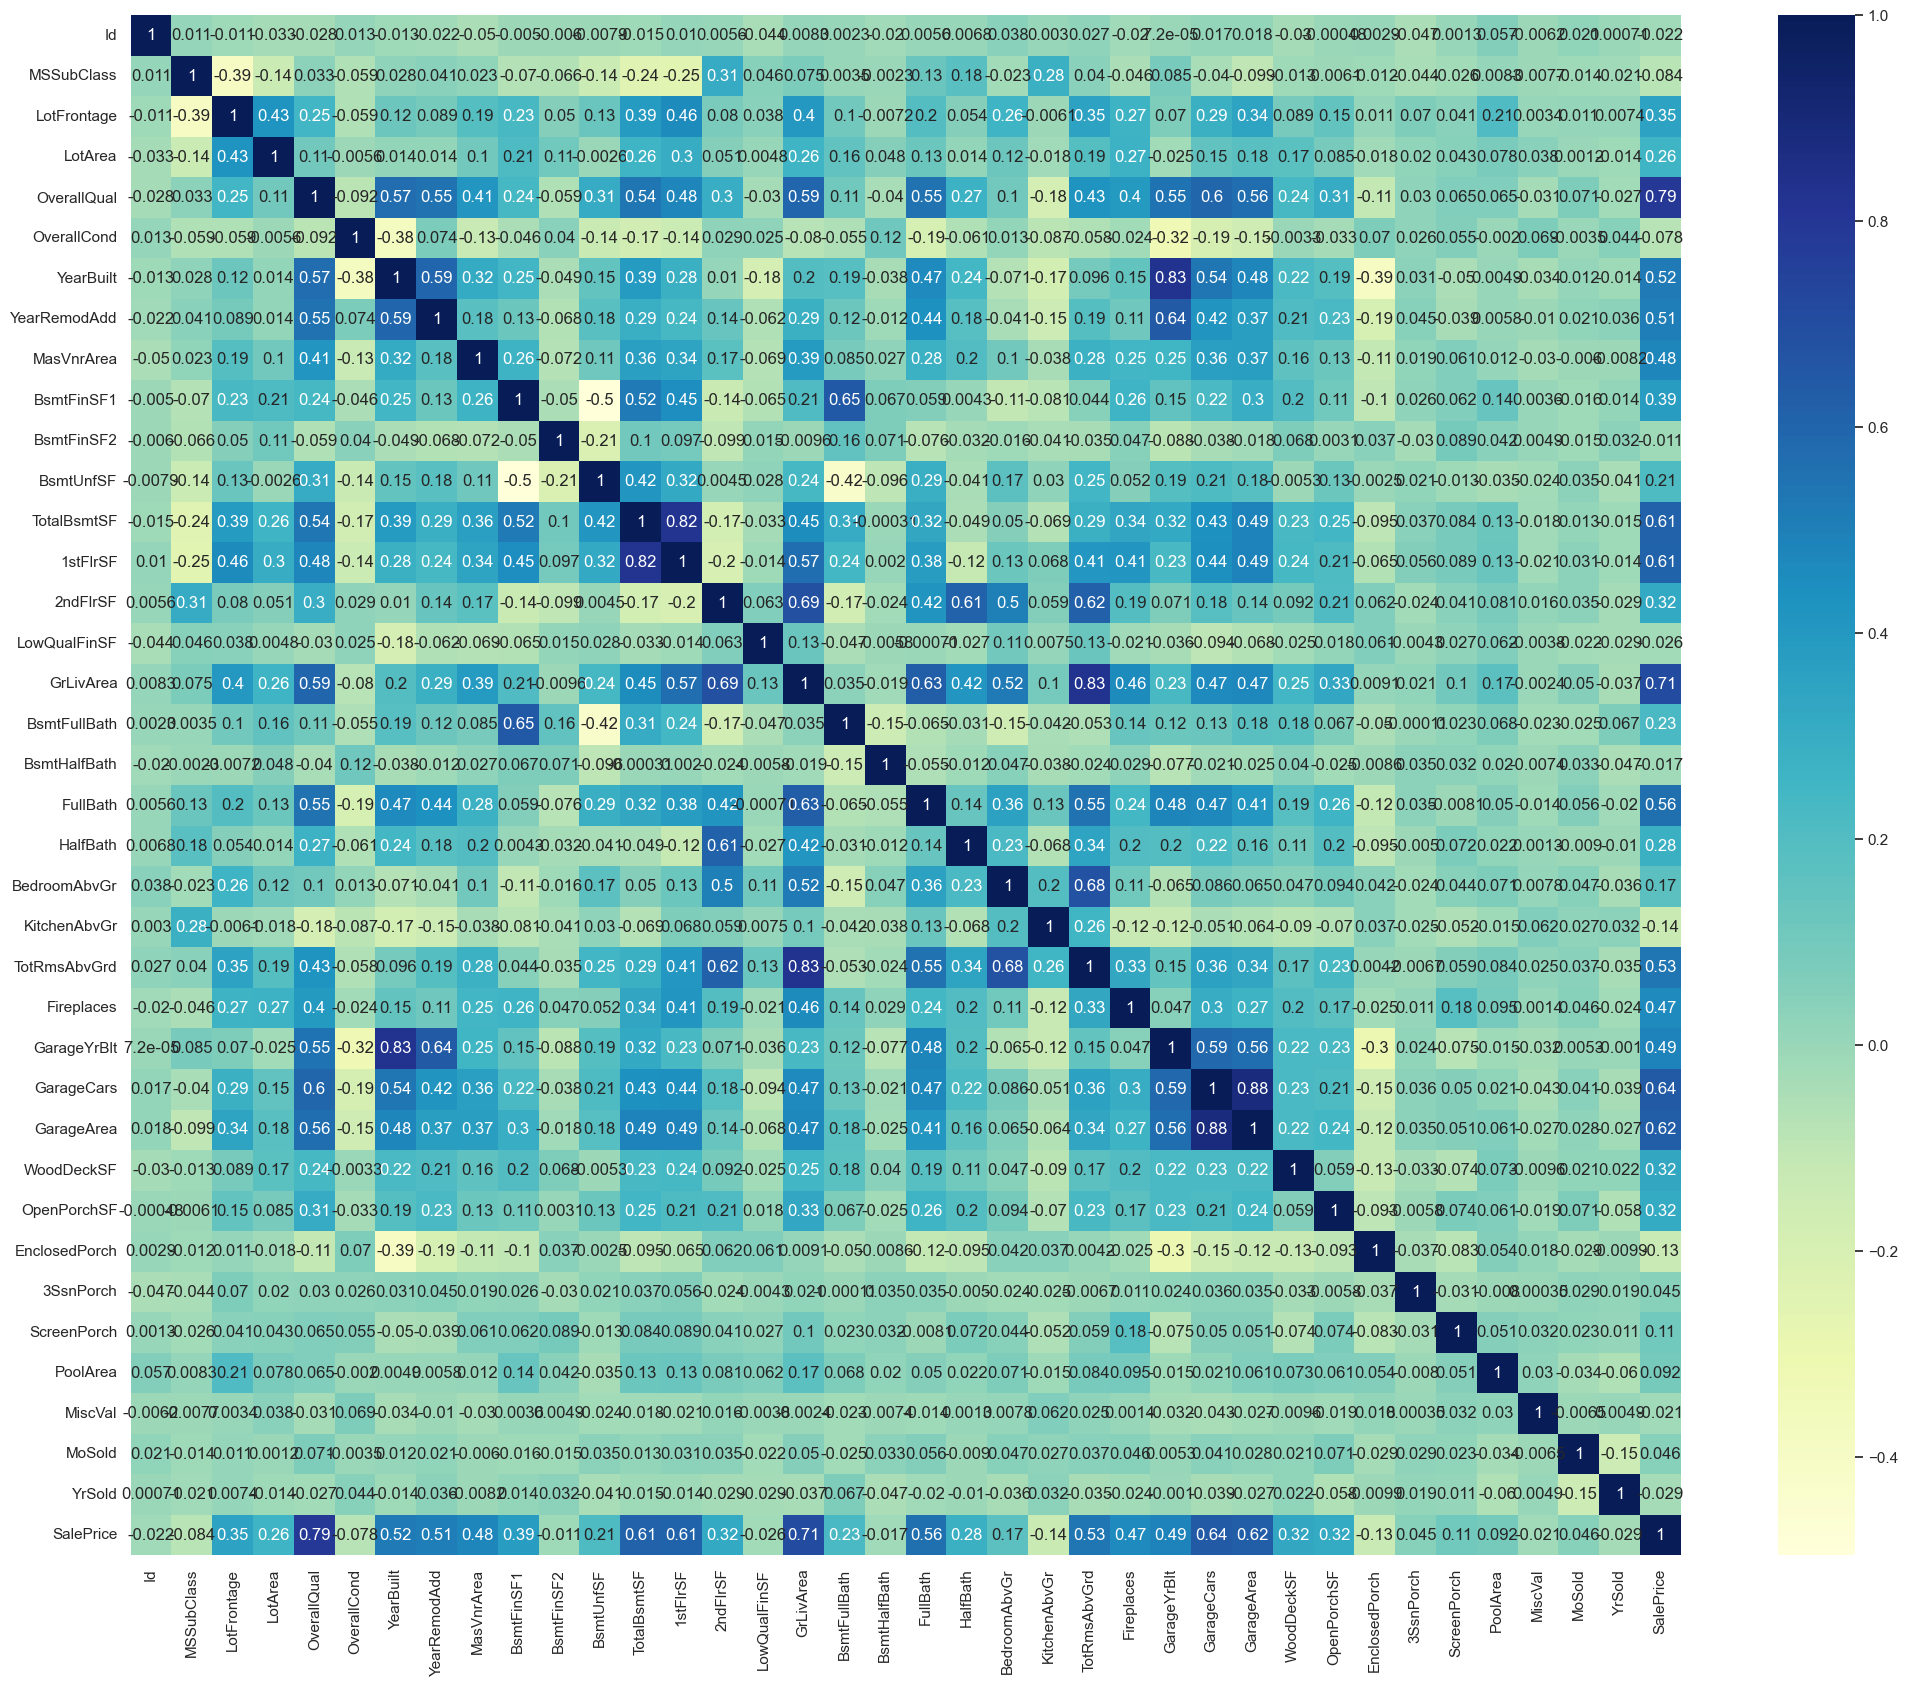

In [626]:
plt.figure(figsize = (25, 20))
sns.heatmap(df.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [627]:
### Dropping below columns as the correlation with sale prce is very low
df = df.drop(columns = ['Id', 'OverallCond', 'MoSold', 'YrSold'])


In [628]:
### Dropping GarageCars, GarageYrBlt, TotRmsAbvGrd and TotalBsmtSF as the correlation with GarageArea, YearBuilt, GrLivArea and 1stFlrSF is high respectively
df=df.drop(columns = ['GarageCars', 'GarageYrBlt', 'TotRmsAbvGrd', 'TotalBsmtSF'])

## Missing data

In [629]:
#missing data
total = df.isnull().sum().sort_values(ascending=False)
total.head()

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
FireplaceQu     690
dtype: int64

In [630]:
### In this data frame some columns has NA values which actually does not mean Null, so changing the NA value to appropriate values
nonnull=['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature','FireplaceQu']

for i in nonnull:
    df[i].fillna("None", inplace=True)
    df[i].fillna("None", inplace=True)


In [631]:
df['Alley'].head()

0    None
1    None
2    None
3    None
4    None
Name: Alley, dtype: object

In [632]:
#missing data
total = df.isnull().sum().sort_values(ascending=False)
total.head()

LotFrontage    259
MasVnrType       8
MasVnrArea       8
Electrical       1
HalfBath         0
dtype: int64

In [633]:
df.drop('LotFrontage', axis=1, inplace=True)

In [634]:
df["MasVnrArea"].fillna(df["MasVnrArea"].median(), inplace=True)
df["MasVnrType"].fillna("None", inplace=True)

In [635]:
df.dropna(inplace=True)

In [636]:
total = df.isnull().sum().sort_values(ascending=False)
total.head()

MSSubClass     0
MSZoning       0
FireplaceQu    0
Fireplaces     0
Functional     0
dtype: int64

## Data Preparation

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

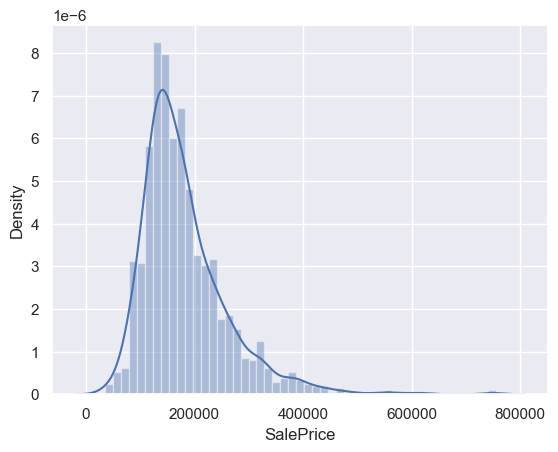

In [637]:
sns.distplot(df["SalePrice"])

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

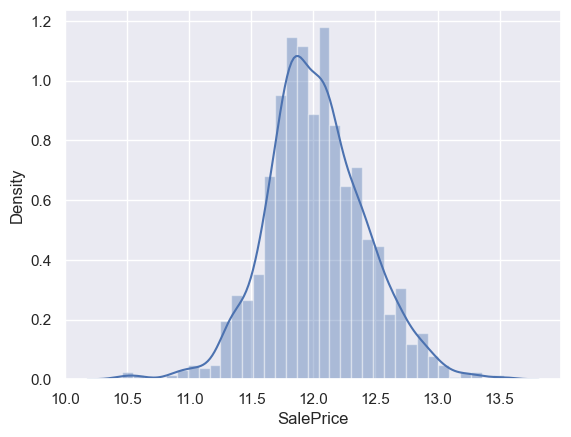

In [638]:
sns.distplot(np.log(df["SalePrice"]))

In [639]:
df["TransformedPrice"] = np.log(df["SalePrice"])

In [640]:
types_train = df.dtypes
num_train = types_train[(types_train == 'int64') | (types_train == float)] #numerical values are either type int or float
cat_train = types_train[types_train == object] #categorical values are type object

In [641]:
numerical_values_train = list(num_train.index) # Numerical features in data
categorical_values_train = list(cat_train.index) # Categorical features in data

In [642]:
for i in categorical_values_train:
    feature_set = set(df[i])
    for j in feature_set:
        feature_list = list(feature_set)
        df.loc[df[i] == j, i] = feature_list.index(j)

In [643]:
df.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,SaleType,SaleCondition,SalePrice,TransformedPrice
0,60,2,8450,1,0,1,1,0,1,0,...,0,0,0,0,0,0,6,0,208500,12.247694
1,20,2,9600,1,0,1,1,0,0,0,...,0,0,0,0,0,0,6,0,181500,12.109011
2,60,2,11250,1,0,0,1,0,1,0,...,0,0,0,0,0,0,6,0,223500,12.317167
3,70,2,9550,1,0,0,1,0,3,0,...,0,0,0,0,0,0,6,4,140000,11.849398
4,60,2,14260,1,0,0,1,0,0,0,...,0,0,0,0,0,0,6,0,250000,12.429216


#### Splitting the data into Training and Testing Sets

In [644]:
X = df.drop(["SalePrice", "TransformedPrice"], axis=1).values
y = df["TransformedPrice"].values

In [645]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.70, test_size = 0.30, random_state = 100)

## Linear Regression

In [646]:
#Unregularized Model
from sklearn.linear_model import LinearRegression,Lasso, Ridge
lr = LinearRegression()
lr.fit(X_train,y_train)
print("Training R2")
print(lr.score(X_train,y_train))
print("Testing R2")
print(lr.score(X_test,y_test))

Training R2
0.8961328999116358
Testing R2
0.08827526460345714


In [647]:
#If alpha=0 then overfitting [Unregularised Model]
#Higher the alpha more the regularization more the underfitting
#Lower the alpha lesser the regularization more the overfitting
lr = Lasso(alpha=0.9)
lr.fit(X_train,y_train)
print("Training R2")
print(lr.score(X_train,y_train))
print("Testing R2")
print(lr.score(X_test,y_test))

Training R2
0.775364092794548
Testing R2
0.7646542997822854


In [648]:
lr.coef_

array([-6.36226805e-05,  0.00000000e+00,  1.40272941e-06,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        2.76099239e-03,  1.32955515e-03, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  4.11226618e-05,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.99902684e-04,
       -0.00000000e+00,  1.34403289e-04,  1.45467337e-04,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.65423847e-05, -0.00000000e+00,  2.99487127e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

## Ridge and Lasso Regression

### Ridge

In [649]:
#Generate a list of 50 values between 0 and 1.5
params = {'alpha': np.linspace(0.2, 0.6 , num = 100) }

In [650]:
# list of alphas to tune
params = {'alpha': [0.00000001,0.0000001,0.000001,0.00001,0.0001, 0.001, 0.01, 0.05, 0.1,
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

In [651]:
# Importing the relevant libraries
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

In [652]:
# Applying Ridge
ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge,
                        param_grid = params,
                        scoring= 'neg_mean_absolute_error',
                        cv = folds,
                        return_train_score=True,
                        verbose = 1)
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                   0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0,
                                   7.0, 8.0, 9.0, 10.0, 20, 50, 100, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [653]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.005613,0.000792,0.001397,0.000798,0.0,{'alpha': 1e-08},-0.085188,-0.103176,-0.106924,-0.118284,...,-0.103112,0.010651,18,-0.091227,-0.087354,-0.080859,-0.088664,-0.088772,-0.087375,0.003491
1,0.004615,0.000780,0.001396,0.000489,0.0,{'alpha': 1e-07},-0.085188,-0.103176,-0.106924,-0.118284,...,-0.103112,0.010651,17,-0.091227,-0.087354,-0.080859,-0.088664,-0.088772,-0.087375,0.003491
2,0.004016,0.000880,0.001197,0.000399,0.000001,{'alpha': 1e-06},-0.085188,-0.103176,-0.106924,-0.118283,...,-0.103112,0.010651,16,-0.091227,-0.087354,-0.080859,-0.088664,-0.088772,-0.087375,0.003491
3,0.002993,0.000631,0.001020,0.000046,0.00001,{'alpha': 1e-05},-0.085188,-0.103176,-0.106924,-0.118280,...,-0.103111,0.010650,15,-0.091227,-0.087354,-0.080859,-0.088664,-0.088772,-0.087375,0.003491
4,0.003206,0.000744,0.000797,0.000399,0.0001,{'alpha': 0.0001},-0.085189,-0.103176,-0.106924,-0.118247,...,-0.103105,0.010640,14,-0.091228,-0.087354,-0.080859,-0.088665,-0.088772,-0.087376,0.003491


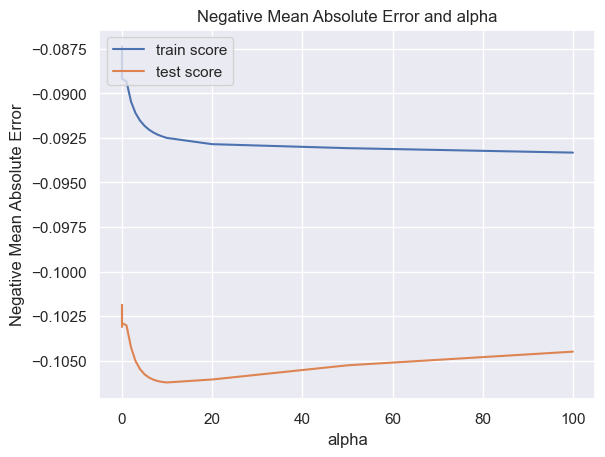

In [654]:
# plotting mean test and train scoes with alpha
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [655]:
alpha = 10
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([-7.90591762e-04,  1.10790623e-02,  1.73938422e-06,  4.31736324e-02,
       -8.24655822e-03, -8.23219060e-03, -2.16004265e-02, -8.13687501e-03,
        6.64069832e-03,  2.18250319e-02, -1.80756051e-03,  1.04850573e-02,
        1.57105721e-02, -1.93213109e-02, -1.97976624e-03,  8.04388179e-02,
        1.18565585e-03,  2.24811861e-03, -8.44665494e-03,  4.62014028e-03,
        2.92287300e-03, -4.20144265e-04, -1.24856225e-03,  1.11694664e-05,
       -1.93070482e-02,  1.01823792e-02,  1.49337965e-02,  8.70557117e-03,
       -8.96351268e-03,  3.80058595e-03,  7.83963900e-03,  7.08225317e-05,
        3.70110458e-03,  2.55616643e-05,  5.81255608e-05,  1.56681924e-02,
        8.71454189e-03, -7.31925102e-02,  3.03365093e-03,  6.93556906e-05,
        8.86593467e-05, -6.47166032e-06,  1.51543381e-04,  6.06000415e-02,
        3.74076354e-02,  3.73098391e-02,  1.75355194e-02,  7.10886931e-03,
       -1.91824840e-02,  1.67066555e-02, -1.43202685e-02,  3.29627802e-02,
        4.45810961e-03, -

In [656]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
lr = RandomForestRegressor()
lr.fit(X_train,y_train)
print("Training R2")
print(lr.score(X_train,y_train))
print("Testing R2")
print(lr.score(X_test,y_test))

Training R2
0.981438705644349
Testing R2
0.8521943326595138


In [657]:
# Applying Lasso
lasso = Lasso()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = lasso,
                        param_grid = params,
                        scoring= 'r2',
                        cv = folds,
                        return_train_score=True,
                        verbose = 1)

model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                   0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0,
                                   7.0, 8.0, 9.0, 10.0, 20, 50, 100, ...]},
             return_train_score=True, scoring='r2', verbose=1)

In [658]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.017936,0.010263,0.001197,0.000398,0.0,{'alpha': 1e-08},0.916655,0.862174,0.785227,0.270057,...,0.738249,0.237794,8,0.887766,0.898674,0.918999,0.898510,0.893369,0.899463,0.010556
1,0.016513,0.014412,0.004130,0.005792,0.0,{'alpha': 1e-07},0.916654,0.862176,0.785228,0.271202,...,0.738479,0.237344,7,0.887766,0.898674,0.918999,0.898509,0.893369,0.899463,0.010556
2,0.018836,0.006400,0.000000,0.000000,0.000001,{'alpha': 1e-06},0.916641,0.862197,0.785239,0.282594,...,0.740769,0.232864,6,0.887766,0.898674,0.918999,0.898507,0.893369,0.899463,0.010556
3,0.014598,0.008357,0.000000,0.000000,0.00001,{'alpha': 1e-05},0.916517,0.862406,0.785350,0.390487,...,0.762459,0.190604,4,0.887765,0.898672,0.918997,0.898473,0.893368,0.899455,0.010556
4,0.007150,0.007111,0.003123,0.006247,0.0001,{'alpha': 0.0001},0.915229,0.864303,0.786380,0.591065,...,0.803604,0.113942,2,0.887684,0.898578,0.918875,0.898251,0.893306,0.899339,0.010542


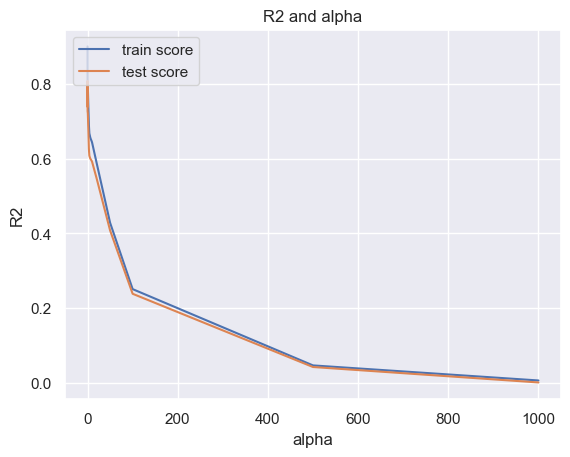

In [659]:
# plotting mean test and train scoes with alpha
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2')

plt.title("R2 and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [660]:
alpha = 0.5

lasso = Lasso(alpha=alpha)

lasso.fit(X_train, y_train)

Lasso(alpha=0.5)

In [661]:
lasso.coef_

array([-3.51808544e-04,  0.00000000e+00,  1.53338471e-06,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        2.94047740e-03,  2.28668454e-03, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  3.86914010e-05,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.06681443e-04,
       -0.00000000e+00,  1.49793791e-04,  1.41706716e-04,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        4.44536362e-05, -0.00000000e+00,  2.94342594e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

In [662]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
lr = RandomForestRegressor()
lr.fit(X_train,y_train)
print("Training R2")
print(lr.score(X_train,y_train))
print("Testing R2")
print(lr.score(X_test,y_test))

Training R2
0.9812392108718755
Testing R2
0.8510523141925324
